This notebook shows how to use `optimex` with a case study of optimizing the transition of an energy system. The case study is highly simplified, not meant to reflect the complexity of energy system but to demonstrate how to use `optimex`. Its structure is based on the demonstration notebooks of [timex](https://github.com/brightway-lca/bw_timex/tree/main/notebooks)

In [1]:
import bw2data as bd
import bw2calc as bc
import logging

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s  - %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

bd.projects.set_current("optimex_ma")
bd.databases

Databases dictionary with 8 object(s):
	biosphere3
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	ei3.10-SSP2-RCP19-2020
	ei3.10-SSP2-RCP19-2030
	ei3.10-SSP2-RCP19-2040
	ei3.10-SSP2-RCP19-2050
	foreground

## Case study setup

The `optimex` package itself does not provide any data - specifying prospective and dynamic information is up to the user. In this example, we use data from ecoinvent v3.10, and create a set of prospective databases with [premise](https://github.com/polca/premise). We applied projections for the future electricity sectors using the SSP2-RCP19 pathway from the IAM IMAGE. We selected this pathway to simply demonstrate some future development in this case study, and many other models and pathways are available. In the premise documentation you can find instructions for the creation of prospective background databases.

In [2]:
ecoinvent_vs = "3.10"

# eidb = bd.Database(f"ecoinvent-{ecoinvent_vs}-cutoff")
db_2020 = bd.Database(f"ei{ecoinvent_vs}-SSP2-RCP19-2020")
db_2030 = bd.Database(f"ei{ecoinvent_vs}-SSP2-RCP19-2030")
db_2040 = bd.Database(f"ei{ecoinvent_vs}-SSP2-RCP19-2040")
db_2050 = bd.Database(f"ei{ecoinvent_vs}-SSP2-RCP19-2050")

First, create a new foreground database:

In [3]:
if "foreground" in bd.databases:
    del bd.databases["foreground"] # to make sure we create the foreground from scratch
foreground = bd.Database("foreground")
foreground.write({})
foreground.register()

The available technologies for our transition have to be in the foreground system. Therefore we copy them from the bg in the fg

In [4]:
original_bg_activities_el = {
    "wind_onshore": db_2020.get(name="electricity production, wind, 1-3MW turbine, onshore", location="DE"),
    "wind_offshore": db_2020.get(name="electricity production, wind, 1-3MW turbine, offshore", location="DE"),
    "hydro_reservoir": db_2020.get(name="electricity production, hydro, reservoir, non-alpine region", location="DE"),
    "hydro_run_of_river": db_2020.get(name="electricity production, hydro, run-of-river", location="DE"),
    "lignite": db_2020.get(name="electricity production, lignite", location="DE"),
    "photovoltaic": db_2020.get(name="electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, panel, mounted", location="DE"),
    # "natural_gas_cogen": db_2020.get(name="heat and power co-generation, natural gas, combined cycle power plant, 400MW electrical", location="DE", unit="kilowatt hour"),
    "wood_chips_cogen": db_2020.get(name="heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014", location="DE", unit="kilowatt hour"),
    "bio_gas_cogen": db_2020.get(name="heat and power co-generation, biogas, gas engine", location="DE", unit="kilowatt hour"),
    "fuel_cell_cogen": db_2020.get(name="electricity, residential, by conversion of hydrogen using fuel cell, PEM, allocated by exergy, distributed by pipeline, produced by Electrolysis, PEM using electricity from grid", unit="kilowatt hour"), 
}

original_bg_activities_heat = {
    "municipal_waste": db_2020.get(name="heat, from municipal waste incineration to generic market for heat district or industrial, other than natural gas", location="DE", unit="megajoule"),
    # "natural_gas_cogen": db_2020.get(name="heat and power co-generation, natural gas, combined cycle power plant, 400MW electrical", location="DE", unit="megajoule"),
    "natural_gas_boiler": db_2020.get(name="heat production, natural gas, at boiler modulating >100kW", location="WEU", unit="megajoule"),
    "wood_chips_cogen": db_2020.get(name="heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014", location="DE", unit="megajoule"),
    "bio_gas_cogen": db_2020.get(name="heat and power co-generation, biogas, gas engine", location="DE", unit="megajoule"),
    "fuel_cell_cogen": db_2020.get(name="heat, residential, by conversion of hydrogen using fuel cell, PEM, allocated by exergy, distributed by pipeline, produced by Electrolysis, PEM using electricity from grid", unit="megajoule"), 
}

for key, act in original_bg_activities_el.items():
    fg_act = act.copy(code=f"elec_prod_{key.replace(' ','_')}", database=foreground.name)
    fg_act["name"] = f"electricity production, {key}, time-explicit"
    fg_act["functional flow"] = "electricity"
    fg_act.save()

for key, act in original_bg_activities_heat.items():
    fg_act = act.copy(f"heat_prod_{key.replace(' ','_')}", database=foreground.name)
    fg_act["name"] = f"heat production, {key}, time-explicit"
    fg_act["functional flow"] = "heat"
    fg_act.save()

[act for act in foreground]

['electricity production, fuel_cell_cogen, time-explicit' (kilowatt hour, CH, None),
 'heat production, bio_gas_cogen, time-explicit' (megajoule, DE, None),
 'electricity production, bio_gas_cogen, time-explicit' (kilowatt hour, DE, None),
 'heat production, fuel_cell_cogen, time-explicit' (megajoule, RER, None),
 'heat production, wood_chips_cogen, time-explicit' (megajoule, DE, None),
 'electricity production, hydro_run_of_river, time-explicit' (kilowatt hour, DE, None),
 'electricity production, photovoltaic, time-explicit' (kilowatt hour, DE, None),
 'electricity production, hydro_reservoir, time-explicit' (kilowatt hour, DE, None),
 'electricity production, wood_chips_cogen, time-explicit' (kilowatt hour, DE, None),
 'electricity production, wind_offshore, time-explicit' (kilowatt hour, DE, None),
 'heat production, natural_gas_boiler, time-explicit' (megajoule, WEU, None),
 'electricity production, lignite, time-explicit' (kilowatt hour, DE, None),
 'heat production, municipal_wa

In [5]:
act = original_bg_activities_heat["natural_gas_boiler"]
act_dict = act.as_dict()
[exc for exc in act.exchanges() if exc["type"] == "technosphere"]

[Exchange: 2.91666666666668e-09 unit 'industrial furnace production, natural gas' (unit, RER, None) to 'heat production, natural gas, at boiler modulating >100kW' (megajoule, WEU, None)>,
 Exchange: 0.00115625 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, WEU, None) to 'heat production, natural gas, at boiler modulating >100kW' (megajoule, WEU, None)>,
 Exchange: 0.0289351851851852 cubic meter 'market group for natural gas, high pressure' (cubic meter, Europe without Switzerland, None) to 'heat production, natural gas, at boiler modulating >100kW' (megajoule, WEU, None)>]

| Power Plant Type                          | Expected Lifetime (Years) |
|-------------------------------------------|---------------------------|
| Wind Turbine                              | 20–25                    |
| Lignite Conventional Power Plant          | 40–50                    |
| Natural Gas Combined Cycle Power Plant    | 25–40                    |
| CHP with Wood Chips                       | 20–30                    |
| CHP with Bio Gas                          | 20-30                    |
| Hydro                                     | 40-80                    |
| Municipal Waste Incineration Power Plant  | 25–35                    |
| Fuel Cell (PEM)                           | 5–15                     |
| Photovoltaic                              | 25–30                    |


### Temporal distribution

Now that the production system is modelled, we can add temporal distributions at the exchange level. 

In [6]:
import numpy as np
import bw_temporalis as bwt


lifetime_dict = {
    "wind_onshore": 22,
    "wind_offshore": 22,
    "hydro_reservoir": 50,
    "hydro_run_of_river": 50,
    "lignite": 45,
    "photovoltaic": 27,
    # "natural_gas_cogen": 36,
    "wood_chips_cogen": 25,
    "bio_gas_cogen": 25,
    "fuel_cell_cogen": 10,
    "municipal_waste": 30,   
}

construction_time_dict = {
    "wind_onshore": 2,
    "wind_offshore": 2,
    "hydro_reservoir": 3,
    "hydro_run_of_river": 3,
    "lignite": 3,
    "photovoltaic": 1,
    # "natural_gas_cogen": 3,
    "wood_chips_cogen": 2,
    "bio_gas_cogen": 2,
    "fuel_cell_cogen": 1,
    "municipal_waste": 2,   
}

In [7]:
#TODO: check for potential improvements for mapping quality based on metadata

def set_temporal_distribution(activity: bd.backends.proxies.Activity, construction_time, lifetime):
    construction_keywords = ["construct", "build", "install", "erect", "assemble", "fabricate", "manufacture"]
    operation_keywords = ["use", "operation", "maintenance", "yearly" , "annual", "supply"]
    end_of_life_keywords = ["end of life", "decommission", "disposal", "recycling"]
    
    td_construction = bwt.easy_timedelta_distribution(
        start=0,
        end=construction_time,
        resolution="Y",
        steps=(construction_time + 1),
        kind="uniform" if construction_time < 2 else "triangular",
    )

    td_use_phase = bwt.easy_timedelta_distribution(
        start=construction_time,
        end=construction_time+lifetime,
        resolution="Y",
        steps=(lifetime + 1),
        kind="uniform",
    )

    td_decommissioning = bwt.TemporalDistribution(
        date=np.array([construction_time + lifetime + 1], dtype="timedelta64[Y]"), amount=np.array([1])
    )

    for exc in activity.exchanges():
        exc_name = exc.input["name"].lower()
        exc_comment = exc.input.get("comment", "").lower()
        phase = None
        
        # Determine the lifecycle phase based on the exchange name
        # if any(keyword in exc_name or exc_comment for keyword in construction_keywords):
        #     phase = "construction"
        # elif any(keyword in exc_name or exc_comment for keyword in end_of_life_keywords):
        #     phase = "decommissioning"
        # elif any(keyword in exc_name or exc_comment for keyword in operation_keywords):
        #     phase = "use"

        if phase == None or exc["type"] == "production": # default to operation
            phase = "use"

        hardcoded_construction_exchanges = [
            "market for dust collector, electrostatic precipitator, for industrial use",
            "market for furnace, wood chips, with silo, 5000kW",
            "market for heat and power co-generation unit, organic Rankine cycle, 1000kW electrical",
            "fuel cell system assembly, 1 kWe, proton exchange membrane (PEM)",
            "market for photovoltaic slanted-roof installation, 3kWp, multi-Si, panel, mounted, on roof",
            "lignite power plant construction",
            "market for wind power plant, 2MW, offshore, fixed parts",
            "market for wind power plant, 2MW, offshore, moving parts",
            "market for wind turbine, 2MW, onshore",
            "market for wind turbine network connection, 2MW, onshore",
            "market for transport, freight, lorry 7.5-16 metric ton, EURO3",
            "gas power plant construction, combined cycle, 400MW electrical",
            "market for hydropower plant, run-of-river",
            "market for hydropower plant, reservoir, non-alpine regions",
            "heat and power co-generation unit construction, 160kW electrical, common components for heat+electricity",
            "heat and power co-generation unit construction, 160kW electrical, components for electricity only",
            "heat and power co-generation unit construction, 160kW electrical, components for heat only",  
            "industrial furnace production, natural gas", 
        ]

        if exc["name"] in hardcoded_construction_exchanges:
            phase = "construction"
            
        if phase == "construction":
            exc["temporal_distribution"] = td_construction
            print(f"activity: {activity['name']}, exchange: {exc['name']}, phase: {phase}")
        elif phase == "use":
            exc["temporal_distribution"] = td_use_phase
        elif phase == "decommissioning":
            exc["temporal_distribution"] = td_decommissioning

         
        exc.save()
    return activity

for act in foreground:
    key = next((k for k in lifetime_dict if k in act['name'].lower()), None)
    if key:
        construction_time = construction_time_dict[key]
        lifetime = lifetime_dict[key]
    set_temporal_distribution(act, construction_time, lifetime)
    act.save()

activity: electricity production, bio_gas_cogen, time-explicit, exchange: heat and power co-generation unit construction, 160kW electrical, common components for heat+electricity, phase: construction
activity: electricity production, bio_gas_cogen, time-explicit, exchange: heat and power co-generation unit construction, 160kW electrical, components for electricity only, phase: construction
activity: electricity production, bio_gas_cogen, time-explicit, exchange: heat and power co-generation unit construction, 160kW electrical, components for heat only, phase: construction
activity: electricity production, wind_onshore, time-explicit, exchange: market for transport, freight, lorry 7.5-16 metric ton, EURO3, phase: construction
activity: electricity production, wind_onshore, time-explicit, exchange: market for wind turbine network connection, 2MW, onshore, phase: construction
activity: electricity production, wind_onshore, time-explicit, exchange: market for wind turbine, 2MW, onshore, ph

We have now defined the available energy technologies, including wind turbines, lignite and natural gas power plants, CHP systems, waste incineration, fuel cells, and photovoltaic systems. The next step is to define the demand curves for electricity (measured in kWh) and heat (measured in MJ).

In [8]:
import numpy as np

demand_el = np.asarray([
    0, 0, 0, 0, 0, 56157, 56437, 55606, 57717, 57773, 55931, 60914, 71943, 84358, 
    98228, 107249, 112607, 111032, 106403, 104333, 102018, 105039, 111936, 111687, 
    110604, 113000, 114266, 119847, 111721, 115637
]) * 1e3

demand_heat = np.asarray([
    0, 0, 0, 0, 0, 262809, 269709, 273258, 298326, 344994, 382277, 428253, 434335, 
    442742, 436880, 444756, 434184, 409388, 408375, 414480, 445917, 443459, 439623, 
    419441, 429527, 423834, 414716, 414119, 407104, 407320
]) * 1e3

years = np.arange(2020, 2050)

td_demand_el = bwt.TemporalDistribution(
    date=np.arange(2020-1970, 30, dtype="datetime64[Y]"), 
    amount=demand_el
)
td_demand_heat = bwt.TemporalDistribution(
    date=np.arange(2020-1970, 30, dtype="datetime64[Y]"), 
    amount=demand_heat
)

demand_input = {
    "electricity": td_demand_el,
    "heat": td_demand_heat,
}

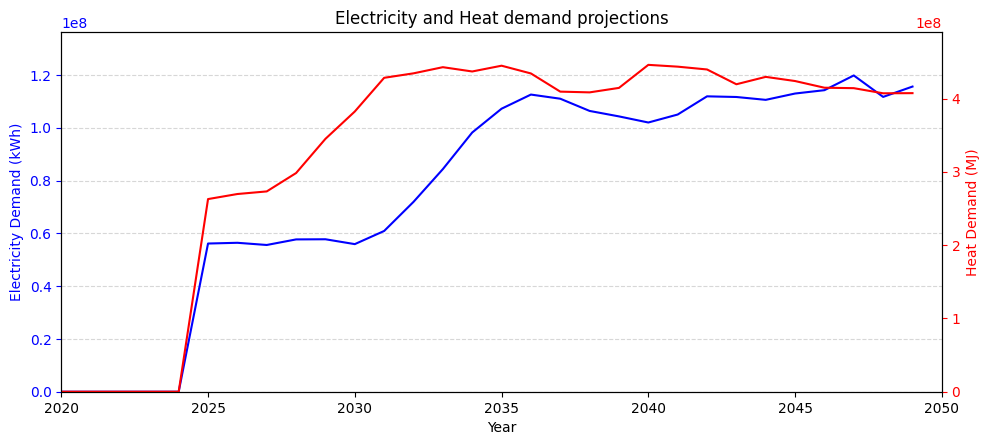

In [9]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6.4 * 0.7))  # Adjust height to be 20% less

# Plot electricity demand on the left y-axis
ax1.plot(years, demand_el, 'b-', label='Electricity Demand (kWh)')
ax1.set_xlabel('Year')
ax1.set_xlim(2020, 2050)
ax1.set_ylabel('Electricity Demand (kWh)', color='b')
ax1.set_ylim(0, 1.1*max(demand_heat)/3.6)
ax1.tick_params('y', colors='b')

# Add horizontal background lines
ax1.yaxis.grid(True, linestyle='--', alpha=0.5)

# Create a second y-axis for heat demand
ax2 = ax1.twinx()
ax2.plot(years, demand_heat, 'r-', label='Heat Demand (MJ)')
ax2.set_ylabel('Heat Demand (MJ)', color='r')
ax2.set_ylim(0, 1.1*max(demand_heat))  # convert MJ to kWh
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.title('Electricity and Heat demand projections')
plt.show()

### Transition pathway optimization

We need to select an impact assessment method to minimize:

In [10]:
# for m in bd.methods:
#     bd.Method(m).process()

In [11]:
method = ('ecoinvent-3.10', 'EF v3.1', 'climate change', 'global warming potential (GWP100)')

`optimex` also needs to know the representative time of the databases:

In [23]:
from datetime import datetime

optimex_type = "static"

database_date_dict = {
    db_2020.name: datetime.strptime("2020", "%Y"),   
    "foreground": "dynamic", # flag databases that should be temporally distributed with "dynamic"
}
if optimex_type == "time_explicit":
    database_date_dict.update({
        db_2030.name: datetime.strptime("2030", "%Y"),
        db_2040.name: datetime.strptime("2040", "%Y"),
        db_2050.name: datetime.strptime("2050", "%Y"),
    })

In [24]:
from optimex import optimex

start_date = datetime.strptime("2020", "%Y")
timehorizon = 50

opt = optimex.Optimex(
    demand = demand_input,
    start_date=start_date,
    method=method,
    database_date_dict = database_date_dict,
    timehorizon=timehorizon,
)

In [25]:
technosphere_tensor, biosphere_tensor, production_tensor = opt.construct_foreground_tensors()

In [26]:
demand_matrix = opt.parse_demand()

In [27]:
import pickle

def save_dict_to_file(tensor, filename):
    with open(filename, 'wb') as f:
        pickle.dump(tensor, f)

def load_dict_from_file(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

load = True
if load:   
    inventory_tensor = load_dict_from_file('inventory_tensor.pkl')
    for key in list(inventory_tensor.keys()):
        if key[0] not in database_date_dict:
            del inventory_tensor[key]
    opt.load_inventory_tensors(inventory_tensor)
else:
    inventory_tensor = opt.sequential_inventory_tensor_calculation(cutoff=1e4)
    save_dict_to_file(inventory_tensor, 'inventory_tensor.pkl')

In [28]:
mapping_matrix = opt.construct_mapping_matrix()

In [29]:
if optimex_type == "time_explicit":
    characterization_matrix = opt.construct_characterization_matrix(dynamic=True, metric="GWP")
else:
    characterization_matrix = opt.construct_characterization_matrix(dynamic=False, metric="GWP")

In [30]:
from optimex.converter import Converter

converter = Converter(opt)

In [31]:
# additional constraint coupling capacity of heat and electricity co-generation
name_process_dict = {v: k for k, v in opt.processes.items()}
process_coupling = {
    # (name_process_dict["heat production, natural_gas_cogen, time-explicit"],
    #   name_process_dict["electricity production, natural_gas_cogen, time-explicit"]): 2.9,
    (name_process_dict["heat production, wood_chips_cogen, time-explicit"],
        name_process_dict["electricity production, wood_chips_cogen, time-explicit"]): 10.8,
    (name_process_dict["heat production, fuel_cell_cogen, time-explicit"],
        name_process_dict["electricity production, fuel_cell_cogen, time-explicit"]): 3.6,
    (name_process_dict["heat production, bio_gas_cogen, time-explicit"],
        name_process_dict["electricity production, bio_gas_cogen, time-explicit"]): 6.18 ,
}

In [32]:
unconstrained_inputs = converter.combine_and_check()
constrained_inputs = converter.combine_and_check(**{
    "process_limits_max_default": 1e8,
    "process_coupling": process_coupling,
})

In [33]:
converter.pickle_model_inputs(f"{optimex_type}_t{timehorizon}_opt_inputs.pkl")

In [24]:
# positive = 0
# negative = 0
# for key, value in inputs_dict.items():
#     if isinstance(value, dict):
#         if key == 'background_inventory':
#             for sub_key, sub_value in value.items():
#                 if isinstance(sub_value, float) and sub_value < 0:
#                     negative += 1
#                 elif isinstance(sub_value, float) and sub_value > 0:
#                     positive += 1
#     elif isinstance(value, float) and value < 0:
#         print(f"Key: {key}, Value: {value}")

# print(f"Positive: {positive}, Negative: {negative}")

In [26]:
from optimex import optimizer

model = optimizer.create_model(constrained_inputs, name = f"optimex_{optimex_type}_heat_elec")


2025-01-21 01:06:02  - INFO - Creating sets
2025-01-21 01:06:02  - INFO - Creating parameters
2025-01-21 01:06:03  - ERROR - Constructing component 'process_limits_min' from data=None failed:
    ValueError: Default value (None) is not valid for Param process_limits_min domain Reals


ValueError: Default value (None) is not valid for Param process_limits_min domain Reals

In [36]:
model, results = optimizer.solve_model(model, compute_iis=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-10
Read LP format model from file C:\Users\HP\AppData\Local\Temp\tmpf02q1t1_.pyomo.lp
Reading time = 0.03 seconds
x1: 305 rows, 201 columns, 4468 nonzeros
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-8365U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 305 rows, 201 columns and 4468 nonzeros
Model fingerprint: 0x60031a47
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+02, 2e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+02, 5e+05]
Presolve removed 274 rows and 110 columns
Presolve time: 0.00s
Presolved: 31 rows, 91 columns, 1617 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.000000e+06   0.000000

In [37]:
results.solver.termination_condition

<TerminationCondition.optimal: 'optimal'>

In [38]:
from optimex.postprocessing import PostProcessor

pp = PostProcessor(model)
pp.get_scaling()

Process,"electricity production, lignite, time-explicit","electricity production, natural gas, time-explicit","electricity production, photovoltaic, time-explicit","electricity production, wind, time-explicit"
Time,,,,
2020,0.0,0.000000,0.000000,50000.0
2021,0.0,0.000000,0.000000,0.0
2022,0.0,0.000000,0.000000,50000.0
2023,0.0,0.000000,0.000000,0.0
2024,0.0,0.000000,0.000000,50000.0
2025,0.0,0.000000,0.000000,0.0
2026,0.0,0.000000,0.000000,50000.0
2027,0.0,0.000000,0.000000,0.0
2028,0.0,0.000000,0.000000,50000.0


In [39]:
pp.get_specific_impacts()

Process,"electricity production, lignite, time-explicit","electricity production, natural gas, time-explicit","electricity production, photovoltaic, time-explicit","electricity production, wind, time-explicit"
Time,,,,
2020,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2021,0.0,0.000000e+00,0.000000e+00,1.270535e+11
2022,0.0,0.000000e+00,0.000000e+00,1.226445e+11
2023,0.0,0.000000e+00,0.000000e+00,1.183001e+11
2024,0.0,0.000000e+00,0.000000e+00,1.140207e+11
2025,0.0,0.000000e+00,0.000000e+00,1.098067e+11
2026,0.0,0.000000e+00,0.000000e+00,1.056585e+11
2027,0.0,0.000000e+00,0.000000e+00,1.015764e+11
2028,0.0,0.000000e+00,0.000000e+00,9.756073e+10


In [40]:
import pandas as pd
import numpy as np
from itertools import combinations
from IPython.display import display

# Example tupled dictionary (b, i, e) -> value
data = converter.model_inputs.background_inventory

# data = {
#     (1, 'i1', 'e1'): 0.5,
#     (1, 'i1', 'e2'): 0.6,
#     (1, 'i2', 'e1'): 0.7,
#     (1, 'i2', 'e2'): 0.8,
#     (2, 'i1', 'e1'): 0.4,
#     (2, 'i1', 'e2'): 0.5,
#     (2, 'i2', 'e1'): 0.6,
#     (2, 'i2', 'e2'): 0.7,
#     (3, 'i1', 'e1'): 0.3,
#     (3, 'i1', 'e2'): 0.4,
#     (3, 'i2', 'e1'): 0.5,
#     (3, 'i2', 'e2'): 0.6,
# }

# Convert dictionary to a DataFrame for easier manipulation
df = pd.DataFrame(
    [
        {"b": b, "i": i, "e": e, "value": value}
        for (b, i, e), value in data.items()
    ]
)

# Pivot data to create matrices for each b (rows: i, columns: e)
matrices = {
    b: group.pivot(index='i', columns='e', values='value').fillna(0)
    for b, group in df.groupby('b')
}

# List of all combinations of b values for pairwise comparison
b_values = list(matrices.keys())
b_combinations = list(combinations(b_values, 2))  # Convert to list

# Initialize a list to store the pairwise differences
pairwise_differences = []

# Compute pairwise differences between all b matrices
for (b1, b2) in b_combinations:
    diff_matrix = matrices[b1] - matrices[b2]
    pairwise_differences.append(diff_matrix)

# Now calculate the mean difference for each 'i' across all pairs of b matrices
# Stack the differences into a single matrix for mean calculation
mean_diff = pd.concat(pairwise_differences, axis=0).groupby(level=0).mean()

# Display the pairwise differences
for (b1, b2), diff_matrix in zip(b_combinations, pairwise_differences):
    print(f"Pairwise difference between {b1} and {b2}")
    # display(pd.DataFrame(diff_matrix))

Pairwise difference between ei3.10-SSP2-RCP19-2020 and ei3.10-SSP2-RCP19-2030
Pairwise difference between ei3.10-SSP2-RCP19-2020 and ei3.10-SSP2-RCP19-2040
Pairwise difference between ei3.10-SSP2-RCP19-2020 and ei3.10-SSP2-RCP19-2050
Pairwise difference between ei3.10-SSP2-RCP19-2030 and ei3.10-SSP2-RCP19-2040
Pairwise difference between ei3.10-SSP2-RCP19-2030 and ei3.10-SSP2-RCP19-2050
Pairwise difference between ei3.10-SSP2-RCP19-2040 and ei3.10-SSP2-RCP19-2050
